## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque 

## Undistort

In [35]:
class Lane_Detection:
    
    objpoints = [] # Camera Calibration object points
    imgpoints = [] # Camera Calibration image points
    mtx = [] # Camera matrix
    dist = [] # Distortion coefficients
    left_fit = [] # 
    right_fit = []
    margin = 100
    # set minimum number of pixels found to recenter window
    minpix = 50       
    nwindows = 9 # choose number of sliding windows
    
    radius = 0 # radius of curvature of the road
    offset = 0 # camera away from the center
    
    left_fit_q = deque(maxlen = 5) # left_lane queue to store previous n(default = 5) lane detection data for averaging out
    right_fit_q = deque(maxlen = 5) # right_lane queue to store previous n(default = 5) lane detection data for averaging out
    
    # Constructor
    def __init__(self, buffer_size = 5):
        self.camera_calibration() # Calibrate camera during object creation
        left_fit_q = deque(maxlen = buffer_size) # option to change the buffer size for averaging out based on no of frames
        right_fit_q = deque(maxlen = buffer_size) # option to change the buffer size for averaging out based on no of frames
    
    # Function to calibrate camera based on the chess board images available.
    # It will save objectpoints, imagepoints, camera matrix and distortion coefficients of the given camera
    def camera_calibration(self):

        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)        
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
        
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape[::-1], None, None)

    # Function to return undistorted image based on camera calibration
    def undistort(self, img):        
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)        
    
    # Function to change image's view to bird eye view
    def warp(self, undst):

        img_size = (undst.shape[1], undst.shape[0])

        # define 4 source points from the detected corners
        # which should form a rectangle on the image
        src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                          [((img_size[0] / 6) - 10), img_size[1]],
                          [(img_size[0] * 5 / 6) + 60, img_size[1]],
                          [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        # define 4 destination points
        dst = np.float32([[(img_size[0] / 4), 0],
                          [(img_size[0] / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), 0]])

        # get transform matrix M using cv2.getPerspectiveTransform
        M = cv2.getPerspectiveTransform(src, dst)

        # warp image to a top down view using cv2.warpPerspective()
        warped = cv2.warpPerspective(undst, M, img_size)
        
        return warped
    
    # Function to find average brightness of the image.
    # This can be used to define various threshold values
    # during color and gradient manipulations
    def avg_brightness(self, rgb_image):
    
        # Convert image to HSV
        hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

        # Add up all the pixel values in the V channel
        sum_brightness = np.sum(hsv[:,:,2])
        
        # and the sum calculated above
        shape = hsv.shape
        avg = sum_brightness/(shape[0]*shape[1])                

        return avg
    
    # Function for color and gradient manipulations to the image
    # to detect clear edges in various lighting conditions
    def color_gradient(self, img):
                
        avg = self.avg_brightness(img) # get average brightness
        
        min_v = (avg - 50) if (avg-50) > 0 else 0
        max_v = (avg + 50) if (avg+50) < 255 else 255       
        s_thresh=(min_v, max_v)
        sx_thresh=(30,100)
        
        # convert to HLS and separate s channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s = hls[:,:,2]
        l = hls[:,:,1]        

        # sobel x
        sobelx = cv2.Sobel(l, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        #threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # threshold color channel
        s_binary = np.zeros_like(s)
        s_binary[(s>s_thresh[0]) & (s<=s_thresh[1])] = 1
        
        combined = np.zeros_like(s)
        
        combined[(s_binary == 1) | (sxbinary == 1)] = 1
        
        return combined

    # Function to find lane pixels
    def find_lane_pixels(self, binary_warped):        

        # take histogram of the bottom half of the image    
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        plt.plot(histogram)
        plt.savefig('output_images/histogram.jpg')
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

        # find the peak of left and right halves of the histogram. These will be the starting point of the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint    

        # set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//self.nwindows)

        # Identify the x and y positions of all non zero pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # step through each windows one by one
        for window in range(self.nwindows):
            # identify window boundries in x and y and right and left            
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = int(leftx_current - self.margin) 
            win_xleft_high = int(leftx_current + self.margin) 
            win_xright_low = int(rightx_current - self.margin)
            win_xright_high = int(rightx_current + self.margin)

            # Identify nonzero pixels in x and y within the window 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
                              (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]
            
            # Draw windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)

            # append these indices to the list
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # if found > minix pixels, recenter next window  
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

            if len(good_right_inds) > self.minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices        
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass        
        
        plt.imshow(out_img)
        plt.savefig('output_images/rectangles.jpg')
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]        

        return leftx, lefty, rightx, righty
    
    # Function to search lane pixels around after already predicted lane lines in the previous image
    def search_around_lanes(self, binary_warped):

        # Get activate pixels
        nonzero = binary_warped.nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])

        # Set the area of the search based on activated x-values within +/- of the margin
        left_lane_inds = ((nonzerox > (self.left_fit[0]*nonzeroy**2 + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) &
                          (nonzerox < (self.left_fit[0]*nonzeroy**2 + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*nonzeroy**2 + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) &
                           (nonzerox < (self.right_fit[0]*nonzeroy**2 + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))
                        
        # extract left and right pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]                          
        
        return leftx, lefty, rightx, righty        

    # Function to fit polynomial to left and right lane pixels and draw lane corresponding to it
    def draw_lane(self, binary_warped):

        # first time find lane pixels
        if not(len(self.left_fit) > 0 and len(self.right_fit) > 0):
            leftx, lefty, rightx, righty = self.find_lane_pixels(binary_warped)
        else:            
            leftx,lefty, rightx, righty = self.search_around_lanes(binary_warped)

        # Fit a second order polynomial to each using np.polyfit        
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        self.left_fit_q.append(self.left_fit)
        self.right_fit_q.append(self.right_fit)
        
        # average out with previous stored left and right lanes polynomials
        if len(list(self.left_fit_q)) > 3:                           # Start averaging out only after 3 frames
            self.left_fit = np.mean(list(self.left_fit_q), axis = 0)
            self.right_fit = np.mean(list(self.right_fit_q), axis = 0)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Calculate Radius of Curvature
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval*ym_per_pix + self.left_fit[1])**2)**1.5)/np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval*ym_per_pix + self.right_fit[1])**2)**1.5)/np.absolute(2*self.right_fit[0])        
        
        self.radius = (left_curverad + right_curverad)/2.0
        
        # Calculate camera from the center / offset
        # compute the offset from the center
        lane_center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1])/2        
        center_offset_pixels = binary_warped.shape[1]/2 - lane_center
        self.offset = xm_per_pix*center_offset_pixels  

        # Visualization of the lane
        points1 = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty)]).astype(np.int32)                       
        points2 = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty)]).astype(np.int32)                        
        points2 = np.flipud(points2)
        points = np.concatenate((points1, points2))

        # output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))  
        
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.imshow(out_img)
        plt.savefig('output_images/lanepixels.jpg')

        cv2.fillPoly(out_img, [points], color=[0,255,0]) # Fill lane with green color

        return out_img
    
    # Opposite of warp() 
    def unwarp(self, warped):
        img_size = (warped.shape[1], warped.shape[0])

        # define 4 source points from the detected corners
        # which should form a rectangle on the image
        src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        # define 4 destination points
        dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])

        # get transform matrix M using cv2.getPerspectiveTransform
        M = cv2.getPerspectiveTransform(dst, src)

        # warp image to a top down view using cv2.warpPerspective()
        unwarped = cv2.warpPerspective(warped, M, img_size)

        return unwarped    
    
    # Function to draw lane over original image and put radius of curavature and offset
    def orignal_image_mask(self, out_img, image):
        result = cv2.addWeighted(image, 1, out_img, 1, 0)
        cv2.putText(result, "Radius of Curvature: %.1f m" % self.radius, (image.shape[1]-600,50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0), 2)
        if self.offset > 0:
            cv2.putText(result, "Vehicle is %.2f m" % self.offset+ " left of center", (image.shape[1]-600,100), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0), 2)
        else:
            cv2.putText(result, "Vehicle is %.2f m" % abs(self.offset)+ " right of center", (image.shape[1]-600,100), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0), 2)
        return result
    
    # Pipeline to process orginal image 
    def process_image_pipeline(self, image):                
        
        img = np.copy(image)

        mask = self.unwarp(self.draw_lane(self.warp(self.color_gradient(self.undistort(img)))))

        result = self.orignal_image_mask(mask, image)

        return result

In [36]:
ld = Lane_Detection()

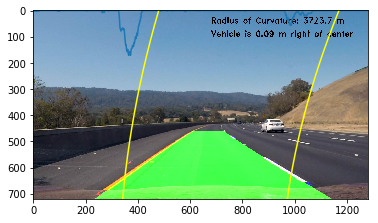

In [37]:
image = mpimg.imread('test_images/test3.jpg')

plt.imshow(image)
plt.savefig('output_images/original.jpg')

undst = ld.undistort(image)

plt.imshow(undst)
plt.savefig('output_images/undst.jpg')

clg = ld.color_gradient(undst)

plt.imshow(clg, cmap='gray')
plt.savefig('output_images/clg.jpg')

warped = ld.warp(clg)

plt.imshow(warped, cmap='gray')
plt.savefig('output_images/warped.jpg')

lane = ld.draw_lane(warped)

plt.imshow(lane)
plt.savefig('output_images/lane.jpg')

unwarped = ld.unwarp(lane)

plt.imshow(unwarped)
plt.savefig('output_images/unwarped.jpg')

result = ld.orignal_image_mask(unwarped, image)

plt.imshow(result)
plt.savefig('output_images/result.jpg')

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
ld1 = Lane_Detection()

In [11]:
project_output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(ld1.process_image_pipeline) 
%time white_clip.write_videofile(project_output, audio=False)

Moviepy - Building video output_video.mp4.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4
Wall time: 32.3 s


In [12]:
del ld1

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))